# Data Preprocessing

Import the libraries.

datapath is initially set to current directory. 

In [1]:
# enter file path for data
datapath = './'

import numpy as np
import matplotlib.pyplot as plt
import csv
import string
import random
import re
import operator
from copy import copy
from nltk.corpus import stopwords 
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

The csv is first read in, and the columns of interest (first and last) are extracted from the csv file.

New binary indicators are made; positive tweets are indicated by 1 and negative tweets are indicated by 0.

In the tweets, all letters are made lowercase so that all the words can be compared with stop words. With all words lowercased, weights are also not case sensitive to words that should be the same. Repeated characters with sequences of length 3 or greater are reduced to sequences of length 3 for consistency among the same words. 

The tweets are then tokenized and stop words are removed. Because there are no emoticons, punctuation is stripped off the ends of each token. Stemming is also used so that words with the same stem and that contribute the same sentiment to a sentence are considered the same.
Handles, numerical digits, and URLs are removed as well since they contribute no sentiment. As many unneccessary words are removed as possible, because there are too many words/features and not enough data.

In [2]:
# read in csv file
csvname = datapath + 'training.1600000.processed.noemoticon.csv'
data = open(csvname, "r", encoding = "ISO-8859-1")
csvReader = csv.reader(data)

all_data = []
for row in csvReader:
    y = int(row[0])
    # lowercase tweet 
    x = row[-1].lower()
    # extract columns of interest (tweet, sentiment)
    # negative and positive indicators converted to 0 and 1
    all_data.append((x,max(0,y-3)))
        
# used to tokenize and remove stop words
tknzr = TweetTokenizer(strip_handles=True,reduce_len=True)
stop_words = set(stopwords.words('english'))
# used to remove digits
remove_digits = str.maketrans('', '', string.digits)
# used to stem
stemmer = PorterStemmer()

for n,instance in enumerate(all_data):
    tweet = instance[0]
    sentiment = instance[1]
    # using regular expressions, remove URLs from tweet 
    tweet = re.sub(r"http://\S+","",tweet)
    tweet = re.sub(r"https://\S+","",tweet)
    tweet = re.sub(r"www.\S+","",tweet)
    tweet = re.sub(r"\S+.com[/\S+]*","",tweet)
    tweet = re.sub(r"\S+.org[/\S+]*","",tweet)
    tweet = re.sub(r"\S+.net[/\S+]*","",tweet)
    # regular expression to remove emails
    tweet =re.sub(r"\S*@\S*\s?","",tweet)
    tokens = tknzr.tokenize(tweet)
    # remove punctuation from ends of each token as well as numerical digits
    for i, token in enumerate(tokens):
        tokens[i] = token.strip(string.punctuation).translate(remove_digits)
    # remove stop words and empty strings
    tokenized_tweet = [word for word in tokens if (word not in stop_words and word != '')]
    # stemming
    tokenized_tweet = [stemmer.stem(token) for token in tokenized_tweet]
    # tuples are used so that each instance is immutable
    all_data[n] = (tokenized_tweet, sentiment)

# verifying tweet tokenization
print(all_data[:10])

[(['awww', "that'", 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day'], 0), (['upset', "can't", 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'also', 'blah'], 0), (['dive', 'mani', 'time', 'ball', 'manag', 'save', 'rest', 'go', 'bound'], 0), (['whole', 'bodi', 'feel', 'itchi', 'like', 'fire'], 0), (['behav', "i'm", 'mad', "can't", 'see'], 0), (['whole', 'crew'], 0), (['need', 'hug'], 0), (['hey', 'long', 'time', 'see', 'ye', 'rain', 'bit', 'bit', 'lol', "i'm", 'fine', 'thank', "how'"], 0), (['nope'], 0), (['que', 'muera'], 0)]


The data is split into training, validation, and test sets with a 60-10-30 split.
Each set has 50% positive examples and 50% negative examples, so that the standard accuracy measure for any model to beat is 50%.

In [3]:
num_examples = len(all_data)
print("total number of examples: ", num_examples)
pos_data = []
neg_data = []
# split positive and negative data into separate lists
for instance in all_data:
    if instance[1] == 1:
        pos_data.append(instance)
    else:
        neg_data.append(instance)
num_pos = len(pos_data)
num_neg = len(neg_data)
print("total number of postive examples: ", num_pos)
print("total number of negative examples: ", num_neg, "\n")

# shuffle all data randomly
random.shuffle(pos_data)
random.shuffle(neg_data)
# 60% training set
training_set = pos_data[:int(num_pos*.6)] + neg_data[:int(num_neg*.6)]
# 10% validataion set
validation_set = pos_data[int(num_pos*.6):int(num_pos*.7)] + neg_data[int(num_neg*.6):int(num_neg*.7)]
# 30% test set
test_set = pos_data[int(num_pos*.7):] + neg_data[int(num_neg*.7):]

# verifying 60-30-10 split and randomization
print("training set length: ", len(training_set))
print(training_set[0],"\n")
print("validation set length: ", len(validation_set))
print(validation_set[0],"\n")
print("testing set length: ", len(test_set))
print(test_set[0],"\n")

total number of examples:  1600000
total number of postive examples:  800000
total number of negative examples:  800000 

training set length:  960000
(['chill', 'sun', 'england', 'think', 'go', 'hardcor', 'run', 'session', 'later'], 1) 

validation set length:  160000
(['point', 'increas', 'effort', 'till', 'work', 'reach', 'free', 'time'], 1) 

testing set length:  480000
(["i'm", 'post', 'ton', 'updat', 'right', "i'm", 'boree'], 1) 



A dictionary of all the word and weight pairs in the training data is created. All weights are initialized to 0 as that pertains to contributing no sentiment to a given tweet, giving an even starting ground for every word. A dictionary is used instead of numpy arrays due to constant time lookup. During gradient descent, only the weights that are relevant in a given tweet will be updated with a dictionary, which is important with a large dataset. 

On the other hand, numpy arrays and matrix math scales linearly to the size of the array/matrix.

In [4]:
# dictionary of all words present in training data with corresponding weight
words = {}
for instance in training_set:
    for word in instance[0]:
        # make unique
        if word not in words:
            # initialization of weight as 0
            words[word] = 0
        
# number of words/features
print("total number of words:",len(words))
# verifying dictionary of words created correctly
iterator = iter(words.items())
for i in range(10):
    print(next(iterator))

total number of words: 180028
('chill', 0)
('sun', 0)
('england', 0)
('think', 0)
('go', 0)
('hardcor', 0)
('run', 0)
('session', 0)
('later', 0)
('inconspicu', 0)


# Stochastic Gradient Descent

All helper functions for gradient descent:

In [5]:
def model(tweet,b,weights):
    '''
    computes linear combination of input points,
    ignores words that haven't been seen in training set
    input:
        tweet - str, tweet from a row of data
        b - float, bias
        weights - dict, dictionary of word, weight pairs
    output:
        model - float, linear combination of WX + b
    '''
    wx = 0
    for word in tweet:
        if word not in weights:
            # ignores words that haven't been seen in training set
            continue
        wx += weights[word]
    model = b + wx
    return model


def ridge_norm(weights):
    '''
    computes squared L2 norm of weights vector
    input:
        weights - dict, dictionary of word, weight pairs
    output:
        norm - float, squared L2 norm of weights vector
    '''
    arr = np.array(list(weights.values()))
    norm = (np.linalg.norm(arr))**2
    return norm

def pos_cost(tweet,reg,b,weights):
    '''
    computes cost for a positive example 
    input:
        tweet - str, tweet from a row of data
        reg - float, ridge penalty value
        b - float, bias
        weights - dict, dictionary of word, weight pairs
    output:
        cost - float, cost for a positive example
    '''
    cost = -np.log(1/(1 + np.exp(-model(tweet,b,weights)))) + (reg/2)*(ridge_norm(weights))
    return cost

def neg_cost(tweet,reg,b,weights):
    '''
    computes cost for a negative example 
    input:
        tweet - str, tweet from a row of data
        reg - float, ridge penalty value
        b - float, bias
        weights - dict, dictionary of word, weight pairs
    output:
        cost - float, cost for a negative example
    '''
    cost = -np.log(1 - 1/(1 + np.exp(-model(tweet,b,weights)))) + (reg/2)*(ridge_norm(weights))
    return cost

def plot_cost_histories(cost_history):
    '''
    plots cost function history plot
    input:
        cost_history - list, list of costs at every 10% of dataset gone through
    output:
        None
    '''
    num_its = len(cost_history)
    iterations = np.linspace(1,num_its,num_its)
    plt.plot(iterations,cost_history)
    plt.title("Cost Function History Plot")
    plt.xlabel("iterations (every 10% of dataset)")
    plt.ylabel("cost")

Gradient descent (with momentum) function with cost calculation:

The cost function is only calculated every $\frac{1}{10}th$ of the training set for better time efficiency.

In [16]:
# gradient descent function 
def gradient_descent_cost(gamma,max_eps,reg,b,w0,beta):
    '''
    performs binary (ridge) logistic regression with gradient descent 
    input:
        gamma - float, learning rate
        max_eps - int, maximum number of epochs
        reg - float, ridge penalty value
        b - float, bias
        w0 - dict, dictionary of word, weight pairs for initial weights
    output:
        new_weights - dict, dictionary of word, weight pairs for final weights
        cost_history - list, list of costs at every 10% of dataset gone through
    '''
    # copy initial weights
    new_weights = copy(w0)
    # cost function history container
    cost_history = [] 
    
    z = np.zeros((np.shape(w0)))      # momentum term
    
    for k in range(max_eps):
        # randomly shuffle data at beginning of each epoch
        random.shuffle(training_set)
        tweet_counter = 0
        for instance in training_set:
            # remove duplicate words in tweet
            tweet = list(set(instance[0]))
            sentiment = instance[1]
            p = 1/(1 + np.exp(-model(tweet,b,new_weights)))
            for word in tweet:
                # evaluation of cost function gradient
                grad_eval = (p-sentiment) + reg*new_weights[word]
                # take gradient descent step with momentum
                z = beta*z + grad_eval
                new_weights[word] = new_weights[word] - gamma*z  
            
            tweet_counter += 1
            if tweet_counter % (len(training_set)/10) == 0:
                # record cost
                if sentiment == 1:
                    cost = pos_cost(tweet,reg,b,new_weights)
                else:
                    cost = neg_cost(tweet,reg,b,new_weights)
                cost_history.append(cost)      
                
    return new_weights, cost_history

Example run of gradient descent with cost calculations:

final cost: 0.0018443062014402401


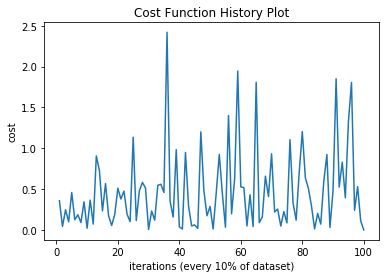

In [17]:
new_w, cost_hist = gradient_descent_cost(10**-2,10,0,0,words,0.6)
plot_cost_histories(cost_hist)  
print("final cost:", cost_hist[-1])

# Validation

For better time complexity, a gradient descent function without cost calculations is defined for validation.

In [18]:
# gradient descent function 
def gradient_descent(gamma,max_eps,reg,b,w0,beta):
    '''
    performs binary (ridge) logistic regression with gradient descent 
    input:
        gamma - float, learning rate
        max_eps - int, maximum number of epochs
        reg - float, ridge penalty value
        b - float, bias
        w0 - dict, dictionary of word, weight pairs for initial weights
    output:
        new_weights - dict, dictionary of word, weight pairs for final weights
    '''
    # copy initial weights
    new_weights = copy(w0)
    z = np.zeros((np.shape(w0)))      # momentum term
    
    for k in range(max_eps):
        # randomly shuffle data at beginning of each epoch
        random.shuffle(training_set)
        tweet_counter = 0
        for instance in training_set:
            # remove duplicate words in tweet
            tweet = list(set(instance[0]))
            sentiment = instance[1]
            p = 1/(1 + np.exp(-model(tweet,b,new_weights)))
            for word in tweet:
                # evaluation of cost function gradient
                grad_eval = (p-sentiment) + reg*new_weights[word]
                # take gradient descent step with momenum
                z = beta*z + grad_eval
                new_weights[word] = new_weights[word] - gamma*z 
            
            tweet_counter += 1  
    return new_weights

`Choosing hyperparameters:`

Function for obtaining validation accuracy:

In [21]:
def get_accuracy(b,weights):
    '''
    gets accuracy of predictions of weights on the validation set
    input:
        b - float, bias
        weights - dict, dictionary of word, weight pairs for initial weights
    output:
        accuracy - float, validation accuracy
    '''
    misclassifications = 0
    for instance in validation_set:
        tweet = instance[0]
        sentiment = instance[1]
        p = 1/(1 + np.exp(-model(tweet,b,weights)))
        p = round(p)
        if p != sentiment:
            misclassifications += 1
    accuracy = 1 - (misclassifications/len(validation_set))
    return accuracy

Words that haven't been seen before are ignored. There's not enough predictive power in any weights given through other methods to an unseen word.

In [34]:
learning_rates = [10**-4,10**-5,10**-6]
max_epochs = [5,7]
ridge_penalties = [10**-2,10**-1,10**0]
bias = [-0.5,0,0.5]
beta = 0

# 1. choose hyperparameters
# 2. train model on training_set, record weights
# 3. test weights on validation set, record accuracy
# 4. train same model 3 times total and get average accuracy
# 5. repeat 1-4 for all combinations of hyperparameters
accuracies = []
model_num = 0
print("Model #| learning rate| max epochs| ridge penalty| bias| average accuracy")
for learning_rate in learning_rates:
    for num in max_epochs:
        for ridge_penalty in ridge_penalties:
            for b in bias:
                validation_accuracy = 0
                for i in range(3):
                    new_w = gradient_descent(learning_rate,num,ridge_penalty,b,words,beta)
                    validation_accuracy += get_accuracy(b,new_w)
                avg_acc = validation_accuracy/3
                model_num += 1
                
                accuracies.append((model_num,avg_acc,[learning_rate,num,ridge_penalty,b]))  
                print(model_num,".      ",learning_rate,"        ",num,"         ",ridge_penalty,"          ",b,"  ",avg_acc)

Model #| learning rate| max epochs| ridge penalty| bias| average accuracy
1 .       0.0001          5           0.01            -0.5    0.6919708333333334
2 .       0.0001          5           0.01            0    0.7352270833333332
3 .       0.0001          5           0.01            0.5    0.7177020833333332
4 .       0.0001          5           0.1            -0.5    0.6879458333333334
5 .       0.0001          5           0.1            0    0.7394625
6 .       0.0001          5           0.1            0.5    0.7167395833333333
7 .       0.0001          5           1            -0.5    0.6008166666666667
8 .       0.0001          5           1            0    0.7487354166666668
9 .       0.0001          5           1            0.5    0.6424958333333334
10 .       0.0001          7           0.01            -0.5    0.7014625
11 .       0.0001          7           0.01            0    0.7397020833333333
12 .       0.0001          7           0.01            0.5    0.72687916666666

These are the parameters that yielded the best average accuracy:

In [35]:
best_params = max(accuracies, key=lambda x:x[1])
print(best_params)

(17, 0.7509208333333334, [0.0001, 7, 1, 0])


Because the highest accuracies appear to be about 75%, parameters that yield similar validation accuracies > 74% are considered for the best model. New parameters around the values of the best parameters are tested on the validation set again.

In [36]:
highest_accs = [x for x in accuracies if x[1] > 0.74]
for params in highest_accs:
    print(params)

(8, 0.7487354166666668, [0.0001, 5, 1, 0])
(14, 0.7437979166666667, [0.0001, 7, 0.1, 0])
(17, 0.7509208333333334, [0.0001, 7, 1, 0])


Testing again on validation set with new parameter values around the best values from the previous test:

In [43]:
learning_rates2 = [10**-2,10**-1]
max_epochs2 = [10,12]
ridge_penalties2 = [0.025,0.25,1]
bias2 = [0,0.25]
beta = 0

accuracies2 = []
model_num = 0
print("Model #| learning rate| max epochs| ridge penalty| bias| average accuracy")
for learning_rate in learning_rates2:
    for num in max_epochs2:
        for ridge_penalty in ridge_penalties2:
            for b in bias2:
                validation_accuracy = 0
                for i in range(3):
                    new_w = gradient_descent(learning_rate,num,ridge_penalty,b,words,beta)
                    validation_accuracy += get_accuracy(b,new_w)
                avg_acc = validation_accuracy/3
                model_num += 1
                
                accuracies2.append((model_num,avg_acc,[learning_rate,num,ridge_penalty,b]))  
                print(model_num,".      ",learning_rate,"        ",num,"         ",ridge_penalty,"          ",b,"  ",avg_acc)

Model #| learning rate| max epochs| ridge penalty| bias| average accuracy
1 .       0.01          10           0.025            0    0.7700104166666666
2 .       0.01          10           0.025            0.25    0.7729354166666665
3 .       0.01          10           0.25            0    0.7668208333333334
4 .       0.01          10           0.25            0.25    0.7660791666666666
5 .       0.01          10           1            0    0.7600750000000001
6 .       0.01          10           1            0.25    0.73538125
7 .       0.01          12           0.025            0    0.7701791666666665
8 .       0.01          12           0.025            0.25    0.7730229166666667
9 .       0.01          12           0.25            0    0.7662729166666667
10 .       0.01          12           0.25            0.25    0.7670145833333334
11 .       0.01          12           1            0    0.7579958333333333
12 .       0.01          12           1            0.25    0.73421458333333

These are the parameters that yielded the best average accuracy for the second validation:

In [44]:
best_params = max(accuracies2, key=lambda x:x[1])
print(best_params)

(8, 0.7730229166666667, [0.01, 12, 0.025, 0.25])


Looking at all models that yielded accuracies > 77% to see if there's a trend or not:

In [45]:
highest_accs = [x for x in accuracies2 if x[1] > 0.77]
for params in highest_accs:
    print(params)

(1, 0.7700104166666666, [0.01, 10, 0.025, 0])
(2, 0.7729354166666665, [0.01, 10, 0.025, 0.25])
(7, 0.7701791666666665, [0.01, 12, 0.025, 0])
(8, 0.7730229166666667, [0.01, 12, 0.025, 0.25])


It appears that there is no significant difference between running gradient descent with either 10 or 12 epochs, as shown with the flattening of the cost function history plot as number of iterations increase. The best learning rate and ridge penalty appear to be $10^{-2}$ and 0.025. The best bias appears to be either 0 and 0.25 with no significant difference between the values.

Because there seems to be no significant difference among the values described, the parameters with the highest average validation accuracy are chosen. Different momentum parameter values are tested as well.

Cost function history plot with the best parameters:

final cost: 30.74477548481591
accuracy: 0.7730125


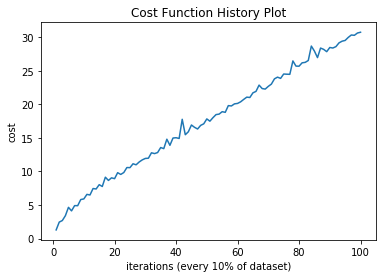

In [46]:
best_w, cost_hist = gradient_descent_cost(10**-2,10,0.025,0.25,words,0)
plot_cost_histories(cost_hist)  
print("final cost:", cost_hist[-1])
# validation set accuracy
acc = get_accuracy(0.25,best_w)
print("accuracy:",acc)

# Testing

Function for obtaining test accuracy:

In [26]:
def test_accuracy(b,weights):
    '''
    gets accuracy of predictions of weights on the test set
    input:
        b - float, bias
        weights - dict, dictionary of word, weight pairs for initial weights
    output:
        test_acc - float, test accuracy
    '''
    misclassifications = 0
    for instance in test_set:
        tweet = instance[0]
        sentiment = instance[1]
        p = 1/(1 + np.exp(-model(tweet,b,weights)))
        p = round(p)
        if p != sentiment:
            misclassifications += 1
    test_acc = 1 - (misclassifications/len(test_set))
    return test_acc

This is the accuracy the best model has on the test set:

In [47]:
test_accuracy(0.25,best_w)

0.7719729166666667

# Top and bottom 5 words (stems) by weight and value of bias

In [24]:
print("The value of the bias term b is 0.25.")
print()
print("Top 5 words by weight:")
for word,weight in dict(sorted(best_w.items(), key=operator.itemgetter(1), reverse=True)[:5]).items():
    print(word,":",weight)
print()
print("Bottom 5 words by weight:")
for word,weight in dict(sorted(best_w.items(), key=operator.itemgetter(1))[:5]).items():
    print(word,":",weight)

The value of the bias term b is 0.25.

Top 5 words by weight:
reliev : 1.5547314205528828
congratul : 1.5126289171320073
thankyou : 1.509120638433089
smile : 1.501181205258176
pleasur : 1.43355243363451

Bottom 5 words by weight:
sad : -2.1954661760520033
sadli : -2.0800385610735725
saddest : -2.054509352771514
disappoint : -1.9679421114548628
unfortun : -1.9336575122856139
